# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [2]:
reports_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/reports/VAE"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/merged"))
verbosity = 1

X = read_data(data_dir, verbosity=verbosity)

Data loaded (8.097157001495361s)


## Training

In [4]:
# On cluster

In [5]:
backend_name = "tensorflow"
computation = "cpu"
name = "mae_2"
project = f"vae_{backend_name}_{computation}_{name}"

model_dir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))
outdir = os.path.join(reports_dir, project)
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [6]:
model = keras.saving.load_model(os.path.join(model_dir, f"{project}_best.keras"), custom_objects=None, compile=True, safe_mode=True)

/home/josua/miniconda3_linux/envs/VAE/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 35 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [7]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   311,956,209 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │        32,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │        32,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   312,781,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249,604,798 (4.66 GB)

 Trainable params: 624,802,398 (2.33 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 624,802,400 (2.33 GB)

## Reconstruction

In [8]:
reconstructed_data = total_ion_count_normalization( pd.DataFrame( model(X).numpy() ), axis=1)

In [9]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc.to_csv( os.path.join(results_dir, f"encoded_mu_{name}.tsv"), sep="\t" )

### Show model

In [10]:
model_plot = keras.utils.plot_model( model, show_shapes=True, show_dtype=False, show_layer_names=True,
                                     rankdir="TB", expand_nested=True, dpi=100, to_file="../../reports/model.png",
                                     show_layer_activations=True, show_trainable=True )

## Plot training

In [11]:
history = pd.read_csv(os.path.join(model_dir, f"{project}.history.tsv"), sep="\t").rename(columns={"Unnamed: 0": "Step",
                                                                                           "loss": "Training Loss", "val_loss": "Validation loss",
                                                                                           "kl_loss": "Training Kullback-Leibler loss", "val_kl_loss": "Validation Kullback-Leibler loss",
                                                                                           "reconstruction_loss": "Training reconstruction loss", "val_reconstruction_loss": "Validation reconstruction loss"})
history

,Step,Training Kullback-Leibler loss,Training Loss,Training reconstruction loss,Validation Kullback-Leibler loss,Validation loss,Validation reconstruction loss
0,0,2.980232e-08,0.839350,0.839350,2.998683e-02,0.471869,0.468441
1,1,1.205068e-01,0.620362,0.606586,4.758507e-03,0.505556,0.505012
2,2,1.882020e-02,0.609858,0.607707,2.042770e-03,0.485460,0.485227
3,3,8.351713e-03,0.609555,0.608600,1.811802e-03,0.495427,0.495219
4,4,7.257611e-03,0.608879,0.608049,1.645714e-03,0.488578,0.488390
...,...,...,...,...,...,...,...
195,195,1.099408e-04,0.603846,0.603833,4.768372e-07,0.472025,0.472025
196,196,1.907349e-06,0.602690,0.602690,8.463860e-06,0.470978,0.470977
197,197,3.319979e-05,0.603812,0.603809,0.000000e+00,0.464604,0.464604
198,198,0.000000e+00,0.604874,0.604874,0.000000e+00,0.471070,0.471070


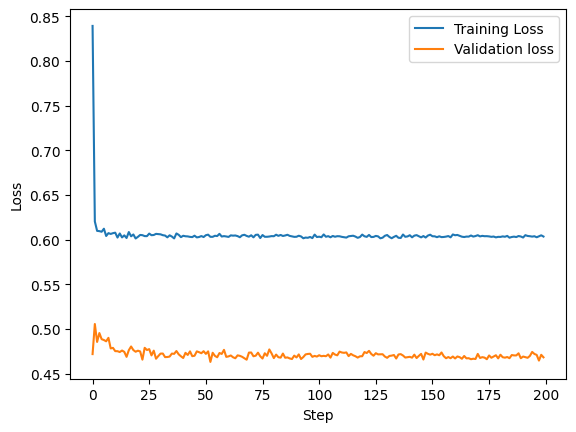

In [12]:
for col in history.columns:
    if col != "Step" and "Kullback-Leibler" not in col and "reconstruction" not in col:
        ax = sns.lineplot(data=history, x="Step", y=col, label=col)
plt.ylabel("Loss")
plt.legend()
plt.show()

## Plot results

### Reconstructed data

In [13]:
reconstructed_data

,0,1,2,3,4,5,6,7,8,9,...,824990,824991,824992,824993,824994,824995,824996,824997,824998,824999
0,0.0,0.0,3.128804e-06,0.0,0.000000,0.0,0.0,0.0,1.237739e-06,0.000005,...,0.0,0.000000e+00,0.000009,0.000000e+00,0.0,0.000004,0.0,0.0,0.000000,0.000014
1,0.0,0.0,4.570316e-06,0.0,0.000000,0.0,0.0,0.0,4.797206e-06,0.000003,...,0.0,4.900258e-06,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,0.000005,0.000000
2,0.0,0.0,4.387302e-07,0.0,0.000003,0.0,0.0,0.0,7.793344e-06,0.000001,...,0.0,3.970066e-06,0.000000,0.000000e+00,0.0,0.000002,0.0,0.0,0.000007,0.000004
3,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,4.851530e-06,0.000007,0.000000e+00,0.0,0.000000,0.0,0.0,0.000010,0.000006
4,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.000005,...,0.0,1.409361e-06,0.000002,1.934077e-07,0.0,0.000009,0.0,0.0,0.000000,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,8.037724e-06,0.000010,...,0.0,7.605558e-07,0.000005,0.000000e+00,0.0,0.000000,0.0,0.0,0.000003,0.000008
132,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.000012,...,0.0,2.649392e-06,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000,0.000011
133,0.0,0.0,0.000000e+00,0.0,0.000001,0.0,0.0,0.0,2.659819e-06,0.000002,...,0.0,9.115466e-06,0.000000,0.000000e+00,0.0,0.000010,0.0,0.0,0.000002,0.000000
134,0.0,0.0,0.000000e+00,0.0,0.000008,0.0,0.0,0.0,9.357904e-07,0.000001,...,0.0,7.304022e-06,0.000000,0.000000e+00,0.0,0.000003,0.0,0.0,0.000005,0.000002


In [14]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [15]:
scale = 1.0
plot_df = pd.DataFrame(reconstructed_data.loc[0].values * scale , index=X.columns, columns=["inty"]).reset_index()    # Adjustment by scale
plot_df_2 = pd.DataFrame(X.iloc[0].values, index=X.columns, columns=["inty"]).reset_index()

In [16]:
mae = np.mean( np.abs((plot_df_2["inty"] - plot_df["inty"])) )
ae = np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) )

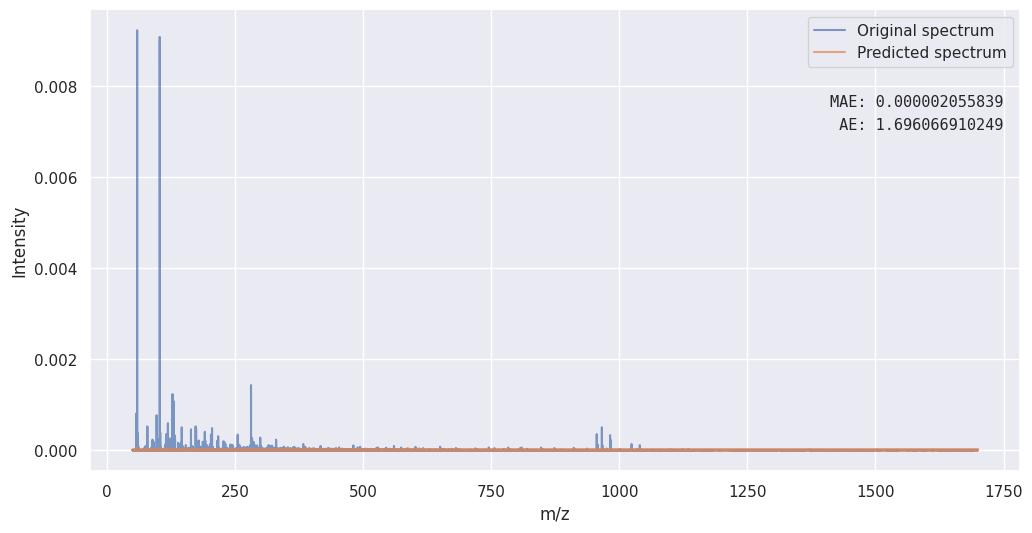

In [17]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7, label="Original spectrum")
predicted_label = "Predicted spectrum" if scale == 1.0 else f"Predicted spectrum (Scale: {scale})"
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7, label=predicted_label)
plt.ylabel("Intensity")
plt.xlabel("m/z")
plt.annotate(f"MAE: {format(mae, '.12f')}", xy=(0.795, 0.79), xycoords='axes fraction', fontsize=11, fontfamily="Monospace")
plt.annotate(f" AE: {format(ae, '.12f')}", xy=(0.795, 0.74), xycoords='axes fraction', fontsize=11, fontfamily="Monospace")
plt.legend()
plt.show()

(-0.0001, 0.003)

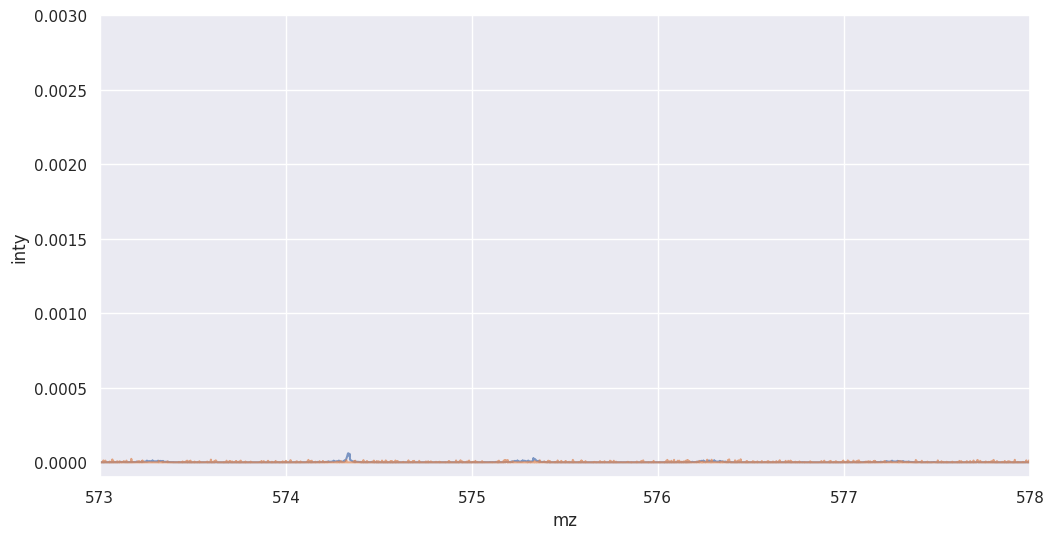

In [18]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

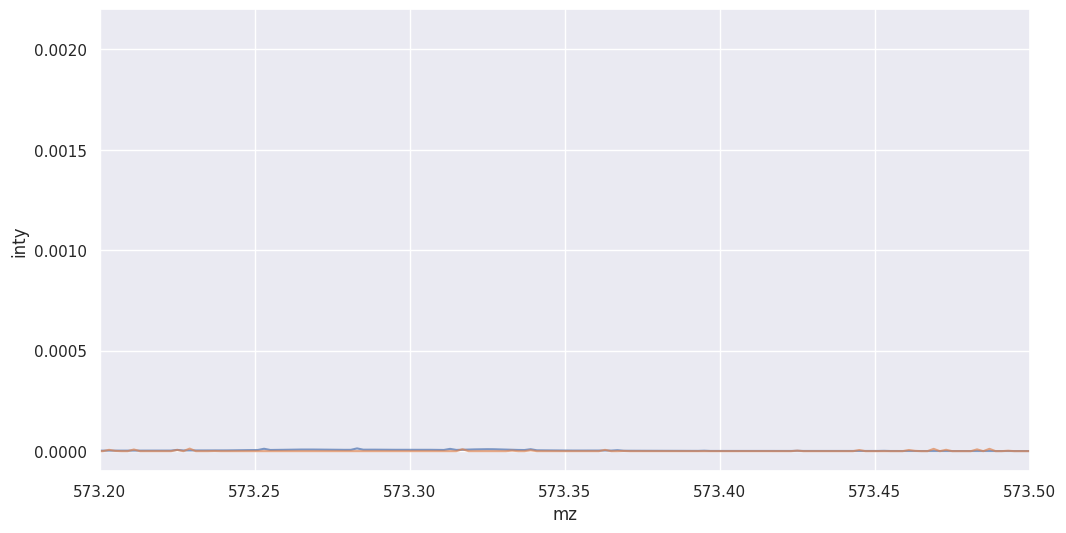

In [19]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

### Latent space

In [20]:
vae_enc

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,3.317386e-06,-2.588058e-08,-3.576159e-06,-1.972427e-06,3.239620e-07,4.158730e-06,-0.000006,-0.000007,7.266644e-07,-0.000007,...,1.444301e-06,-1.096476e-06,-0.000008,6.708797e-07,-2.801844e-07,0.000008,-0.000010,0.000009,-0.000007,-9.269497e-07
1,-1.556378e-06,2.557281e-07,-4.563417e-07,-8.391362e-08,-2.723444e-06,4.152880e-06,-0.000004,-0.000002,4.418791e-06,-0.000003,...,1.198852e-06,3.927127e-06,-0.000003,-1.861933e-06,1.001486e-06,0.000002,-0.000006,0.000005,-0.000002,-2.761306e-06
2,1.290064e-06,1.054847e-06,-2.171817e-06,-1.151560e-06,-1.189534e-06,5.155511e-06,-0.000005,-0.000003,-2.959787e-07,-0.000006,...,1.017579e-07,-5.878755e-07,-0.000007,2.326437e-06,1.596200e-06,0.000007,-0.000007,0.000003,-0.000006,-3.491281e-06
3,-3.381239e-06,2.598499e-06,-5.459933e-07,-8.159168e-07,-3.409412e-06,2.638637e-06,-0.000002,-0.000005,3.289260e-06,-0.000003,...,1.773707e-06,-1.765242e-06,-0.000004,8.191478e-07,1.858194e-06,0.000002,-0.000006,0.000005,-0.000003,-4.523943e-06
4,1.361310e-06,3.815730e-07,-2.709513e-06,-3.286186e-07,1.074204e-07,5.254260e-06,-0.000006,-0.000004,3.131754e-07,-0.000008,...,6.516129e-07,-2.648141e-06,-0.000006,8.494276e-07,3.618552e-07,0.000009,-0.000008,0.000006,-0.000008,-3.150803e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-1.677443e-06,3.523441e-06,1.680301e-07,5.221937e-07,-3.686855e-06,9.579162e-07,-0.000003,-0.000006,2.973768e-06,-0.000004,...,1.010882e-06,3.048299e-07,-0.000007,1.863600e-08,6.765640e-07,0.000001,-0.000007,0.000005,-0.000003,-4.324742e-06
132,2.132649e-06,-1.099201e-06,-1.465140e-06,-3.301133e-06,-7.682847e-07,4.391255e-06,-0.000007,-0.000005,4.929461e-08,-0.000006,...,8.683346e-07,-1.325843e-06,-0.000006,1.608501e-06,1.207014e-06,0.000007,-0.000010,0.000004,-0.000007,-1.883382e-07
133,8.911593e-08,4.494286e-07,-4.274189e-06,2.773309e-06,-2.038598e-06,-2.102646e-06,-0.000004,-0.000008,2.176144e-06,-0.000006,...,6.248702e-07,-2.869455e-06,-0.000012,3.050372e-06,-4.401827e-07,0.000002,-0.000006,0.000002,-0.000003,-1.167478e-06
134,5.379836e-06,-2.148096e-06,-3.967771e-06,-4.126390e-06,-9.281339e-07,5.641225e-06,-0.000007,-0.000006,1.479893e-06,-0.000009,...,9.825308e-07,-8.174902e-08,-0.000006,4.511048e-07,-1.693725e-06,0.000006,-0.000008,0.000008,-0.000007,-1.377703e-07


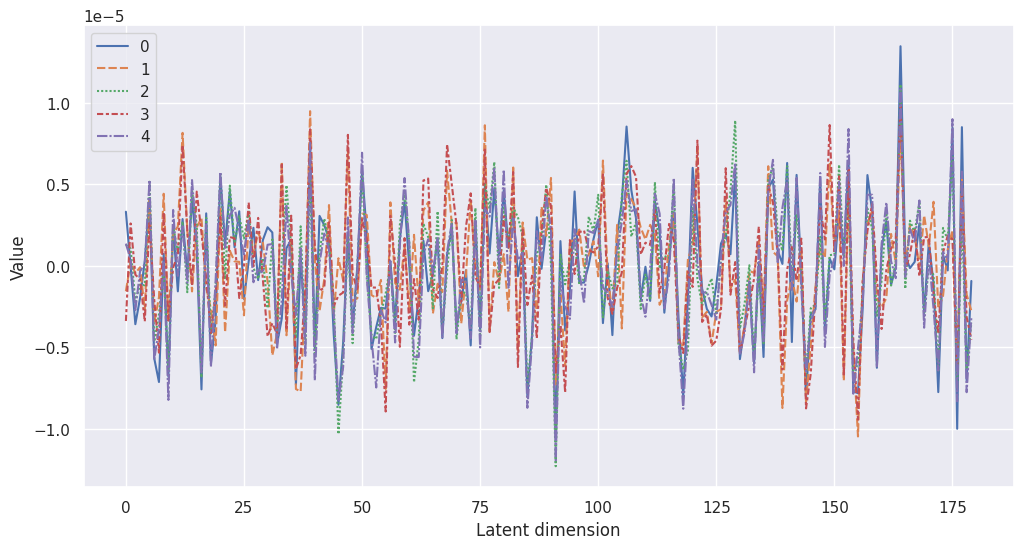

In [21]:
ax = sns.lineplot(data=vae_enc[:5].T)
plt.xlabel("Latent dimension")
plt.ylabel("Value")
plt.savefig( os.path.join(results_dir, f"encoded_mu_5_{name}.png") )
plt.show()